# Supply Network Design 1

## Objective and Prerequisites

Try this Jupyter Notebook Modeling Example to learn how to solve a classic supply network design problem that involves finding the minimum cost flow through a network. We’ll show you how – given a set of factories, depots, and customers – you can use mathematical optimization to determine the best way to satisfy customer demand while minimizing shipping costs.

This model is example 19 from the fifth edition of Model Building in Mathematical Programming, by H. Paul Williams on pages 273-275 and 330-332.

This example is of beginning difficulty; we assume that you know Python and have some knowledge of the Gurobi Python API and building mathematical optimization models.

**Download the Repository** <br />
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

---
## Problem Description

In this problem, we have six end customers, each with a known demand for a product.  Customer demand can be satisfied from a set of four depots, or directly from a set of two factories.  Each depot can support a maximum volume of product moving through it, and each factory can produce a maximum amount of product.  There are known costs associated with transporting the product, from a factory to a depot, from a depot to a customer, or from a factory directly to a customer.

Our supply network has two factories, in Liverpool and Brighton, that produce a product.  Each has a maximum production capacity:

| Factory | Supply (tons) |
| --- | --- |
| Liverpool | 150,000 |
| Brighton |  200,000 |

The product can be shipped from a factory to a set of four depots.  Each depot has a maximum throughput.  Depots don't produce or consume the product; they simply pass the product on to customers.

| Depot | Throughput (tons) |
| --- | --- |
| Newcastle | 70,000 |
| Birmingham | 50,000 |
| London | 100,000 |
| Exeter | 40,000 |

Our network has six customers, each with a given demand.

| Customer | Demand (tons) |
| --- | --- |
| C1 | 50,000 |
| C2 | 10,000 |
| C3 | 40,000 |
| C4 | 35,000 |
| C5 | 60,000 |
| C6 | 20,000 |

Shipping costs are given in the following table (in dollars per ton).  Columns are source cities and rows are destination cities.  Thus, for example, it costs $1 per ton to ship the product from Liverpool to London.  A '-' in the table indicates that that combination is not possible, so for example it is not possible to ship from the factory in Brighton to the depot in Newcastle.

| To | Liverpool | Brighton | Newcastle | Birmingham | London | Exeter |
| --- | --- | --- | --- | --- | --- | --- |
| Depots |
| Newcastle  | 0.5 |   - |
| Birmingham | 0.5 | 0.3 |
| London     | 1.0 | 0.5 |
| Exeter     | 0.2 | 0.2 |
| Customers |
| C1 | 1.0 | 2.0 |   - | 1.0 |   - |   - |
| C2 |   - |   - | 1.5 | 0.5 | 1.5 |   - |
| C3 | 1.5 |   - | 0.5 | 0.5 | 2.0 | 0.2 |
| C4 | 2.0 |   - | 1.5 | 1.0 |   - | 1.5 |
| C5 |   - |   - |   - | 0.5 | 0.5 | 0.5 |
| C6 | 1.0 |   - | 1.0 |   - | 1.5 | 1.5 |

The question to be answered is how to satisfy the demands of the end customers while minimizing shipping costs.

---
## Model Formulation

### Sets and Indices

$f \in \text{Factories}=\{\text{Liverpool}, \text{Brighton}\}$

$d \in \text{Depots}=\{\text{Newcastle}, \text{Birmingham}, \text{London}, \text{Exeter}\}$

$c \in \text{Customers}=\{\text{C1}, \text{C2}, \text{C3}, \text{C4}, \text{C5}, \text{C6}\}$

$\text{Cities} = \text{Factories} \cup \text{Depots} \cup \text{Customers}$

### Parameters

$\text{cost}_{s,t} \in \mathbb{R}^+$: Cost of shipping one ton from source $s$ to destination $t$.

$\text{supply}_f \in \mathbb{R}^+$: Maximum possible supply from factory $f$ (in tons).

$\text{through}_d \in \mathbb{R}^+$: Maximum possible flow through depot $d$ (in tons).

$\text{demand}_c \in \mathbb{R}^+$: Demand for goods at customer $c$ (in tons).

### Decision Variables

$\text{flow}_{s,t} \in \mathbb{N}^+$: Quantity of goods (in tons) that is shipped from source $s$ to destionation $t$.


### Objective Function

- **Cost**: Minimize total shipping costs.

\begin{equation}
\text{Minimize} \quad Z = \sum_{(s,t) \in \text{Cities} \times \text{Cities}}{\text{cost}_{s,t}*\text{flow}_{s,t}}
\end{equation}

### Constraints

- **Factory output**: Flow of goods from a factory must respect maximum capacity.

\begin{equation}
\sum_{t \in \text{Cities}}{\text{flow}_{f,t}} \leq \text{supply}_{f} \quad \forall f \in \text{Factories}
\end{equation}

- **Customer demand**: Flow of goods must meet customer demand.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,c}} = \text{demand}_{c} \quad \forall c \in \text{Customers}
\end{equation}

- **Depot flow**: Flow into a depot equals flow out of the depot.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} = 
\sum_{t \in \text{Cities}}{\text{flow}_{d,t}}
\quad \forall d \in \text{Depots}
\end{equation}

- **Depot capacity**: Flow into a depot must respect depot capacity.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} \leq \text{through}_{d}
\quad \forall d \in \text{Depots}
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [2]:
#%pip install gurobipy

In [46]:
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.12 & Gurobi 12.0

## Input Data
We define all the input data for the model.

In [49]:
# Create dictionaries to capture factory supply limits, depot throughput limits, and customer demand.

supply = dict({'Liverpool': 150000,
               'Brighton': 200000})

through = dict({'Newcastle': 70000,
                'Birmingham': 50000,
                'London': 100000,
                'Exeter': 40000})

demand = dict({'C1': 50000,
               'C2': 10000,
               'C3': 40000,
               'C4': 35000,
               'C5': 60000,
               'C6': 20000})

# Create a dictionary to capture shipping costs.

arcs, cost = gp.multidict({
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C6'): 1.0,
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,
    ('Brighton', 'C1'): 2.0,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C5'): 1.5,
    ('Newcastle', 'C6'): 1.0,
    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5
})

## Model Deployment

We create a model and the variables. The variables simply capture the amount of product that flows along each allowed path between a source and destination.  Objective coefficients are provided here (in $\text{cost}$) , so we don't need to provide an optimization objective later.

In [51]:
model = gp.Model('SupplyNetworkDesign')
flow = model.addVars(arcs, obj=cost, name="flow")

Our first constraints require the total flow along arcs leaving a factory to be at most as large as the supply capacity of that factory.

In [54]:
# Production capacity limits

factories = supply.keys()
factory_flow = model.addConstrs((gp.quicksum(flow.select(factory, '*')) <= supply[factory]
                                 for factory in factories), name="factory")

Our next constraints require the total flow along arcs entering a customer to be equal to the demand from that customer.

In [57]:
# Customer demand

customers = demand.keys()
customer_flow = model.addConstrs((gp.quicksum(flow.select('*', customer)) == demand[customer]
                                  for customer in customers), name="customer")

Our final constraints relate to depots.  The first constraints require that the total amount of product entering the depot must equal the total amount leaving.

In [60]:
# Depot flow conservation

depots = through.keys()
depot_flow = model.addConstrs((gp.quicksum(flow.select(depot, '*')) == gp.quicksum(flow.select('*', depot))
                               for depot in depots), name="depot")

The second set limits the product passing through the depot to be at most equal the throughput of that depot.

In [63]:
# Depot throughput

depot_capacity = model.addConstrs((gp.quicksum(flow.select('*', depot)) <= through[depot]
                                   for depot in depots), name="depot_capacity")

## Visualizing the problem

We can draw the directed graph with **graphviz** package.

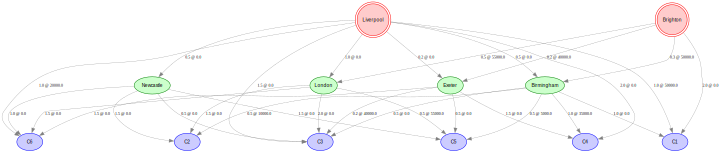

In [136]:
from graphviz import Digraph

# Define colours and styles
factory_style = {'shape': 'doublecircle', 'color': 'red', 'style': 'filled', 'fillcolor': '#FFCCCC'}
depot_style = {'color': 'green', 'style': 'filled', 'fillcolor': '#CCFFCC'}
customer_style = {'color': 'blue', 'style': 'filled', 'fillcolor': '#CCCCFF'}
edge_style = {'color': 'gray', 'penwidth': '0.5'}

# Create the graph with some layout settings
dot = Digraph(graph_attr={'rankdir': 'TB',     # TOP-to_Bottom
                          'size': '10,10',     # Larger image
                          'nodesep': '0.5',    # Distance between nodes
                          'ranksep': '1.0'     # Distance between levels
                         },
              node_attr={'fontsize': '10',
                         'fontname': 'Arial'
                        },
              edge_attr=edge_style
             )

# Add nodes with styles
for factory in factories:
    dot.node(factory,  **factory_style)
for depot in depots:
    dot.node(depot, **depot_style)
for customer in customers:
    dot.node(customer, **customer_style)

# Add edges with costs as labels    
for arc in arcs:
    dot.edge(arc[0], arc[1],
             label=f"{cost[arc[0],arc[1]]}", 
             fontsize='8', 
             fontcolor='black')
        
dot

We now optimize the model

In [69]:
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16 rows, 29 columns and 65 nonzeros
Model fingerprint: 0x3607c855
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 2e+05]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 15 rows, 29 columns, 64 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4800000e+05   1.812500e+04   0.000000e+00      0s
       7    1.9850000e+05   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.985000000e+05


---
## Analysis

Product demand from all of our customers can be satisfied for a total cost of $\$198,500$. The optimal plan is as follows.

In [72]:
product_flow = pd.DataFrame(
    [{"From": arc[0], "To": arc[1], "Flow": flow[arc].x} for arc in arcs if flow[arc].x > 1e-6]
)
product_flow.index = [''] * len(product_flow)
product_flow

,From,To,Flow
,Liverpool,C1,50000.0
,Liverpool,C6,20000.0
,Brighton,Birmingham,50000.0
,Brighton,London,55000.0
,Brighton,Exeter,40000.0
,Birmingham,C2,10000.0
,Birmingham,C4,35000.0
,Birmingham,C5,5000.0
,London,C5,55000.0
,Exeter,C3,40000.0


## Visualize flows

In [138]:
def draw_solution(model, flow):
    
    # Define colours and styles
    factory_style = {'shape': 'doublecircle', 'color': 'red', 'style': 'filled', 'fillcolor': '#FFCCCC'}
    depot_style = {'color': 'green', 'style': 'filled', 'fillcolor': '#CCFFCC'}
    customer_style = {'color': 'blue', 'style': 'filled', 'fillcolor': '#CCCCFF'}
    edge_style = {'color': 'gray', 'penwidth': '0.5'}

    # Create the graph with some layout settings
    dot = Digraph(graph_attr = {'rankdir': 'TB',
                              'size': '10,10',
                              'nodesep': '0.5',
                              'ranksep': '1.0'
                               },
                 node_attr = {'fontsize': '10',
                            'fontname': 'Arial'
                             },
                 edge_attr = edge_style
                 )
    # Add factory-nodes with styles
    for factory in factories:
        dot.node(factory,  **factory_style)
    #Add depot-nodes with styles
    for depot in depots:
        dot.node(depot, **depot_style)
    # Add customer-nodes with styles
    for customer in customers:
        dot.node(customer, **customer_style)

    # Add edges with costs as labels 
    for arc in arcs:
        if flow[arc].X > 0:
            dot.edge(arc[0], arc[1],
                     label=f"{cost[arc[0], arc[1]]}  @ {flow[arc[0],arc[1]].X}",
                     color='red',
                     fontsize='10'
                    )
        else:
            dot.edge(arc[0], arc[1],
                     fontsize='8', 
                     fontcolor='black'
                    )

    return dot


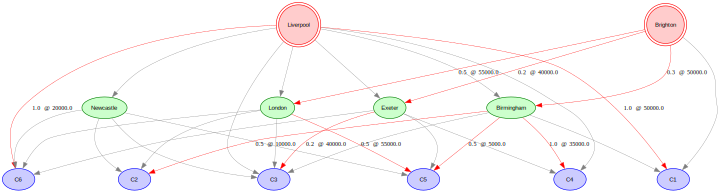

In [140]:
draw_solution(model, flow)

---
## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC